In [1]:
import aacgmv2
import os
import sys
import psycopg2

import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from itertools import chain
from tqdm import tqdm

from utils import local_data
%matplotlib inline

In [2]:
df_station = pd.read_pickle(os.path.join(local_data, 'df_station.pkl'))

In [3]:
dtime = dt.datetime(2013, 1, 1)
mag_lat = []
mag_lon = []
for i in df_station.itertuples():
    if np.isnan(i.height):
        height = 300
    else:
        height = i.height
    mag_latitude, mag_longitude, _ = aacgmv2.get_aacgm_coord(i.latitude, 
                                                             i.longitude, 
                                                             height, 
                                                             dtime)
    mag_lat.append(mag_latitude)
    mag_lon.append(mag_longitude)
    
df_station['mag_latitude'] = np.array(mag_lat)
df_station['mag_longitude'] = np.array(mag_lon)

In [4]:
dtime = dt.datetime(2013, 1, 1)
mag_meridians_lines = []
for lat, lon in zip(mag_lat, mag_lon):
    lats = np.linspace(-90, 90, 720)
    aux_geo_lat = []
    aux_geo_lon = []
    for i in lats:
        geo_lat, geo_lon, _ = aacgmv2.convert_latlon_arr(i, 
                                                         lon, 
                                                         0, 
                                                         dtime=dtime, 
                                                         code="A2G")
        aux_geo_lat.append(float(geo_lat))
        aux_geo_lon.append(float(geo_lon))
        
    mag_meridians_lines.append((aux_geo_lon, aux_geo_lat))

In [5]:
def draw_map(m, scale=0.2):
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 45), labels=[True, True, True, True])
    lons = m.drawmeridians(np.linspace(-180, 180, 90), labels=[True, True, True, True])
    
    # keys contain the plt.line 2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='b')

/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4780: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4781: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4787: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4818: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4818: Runti

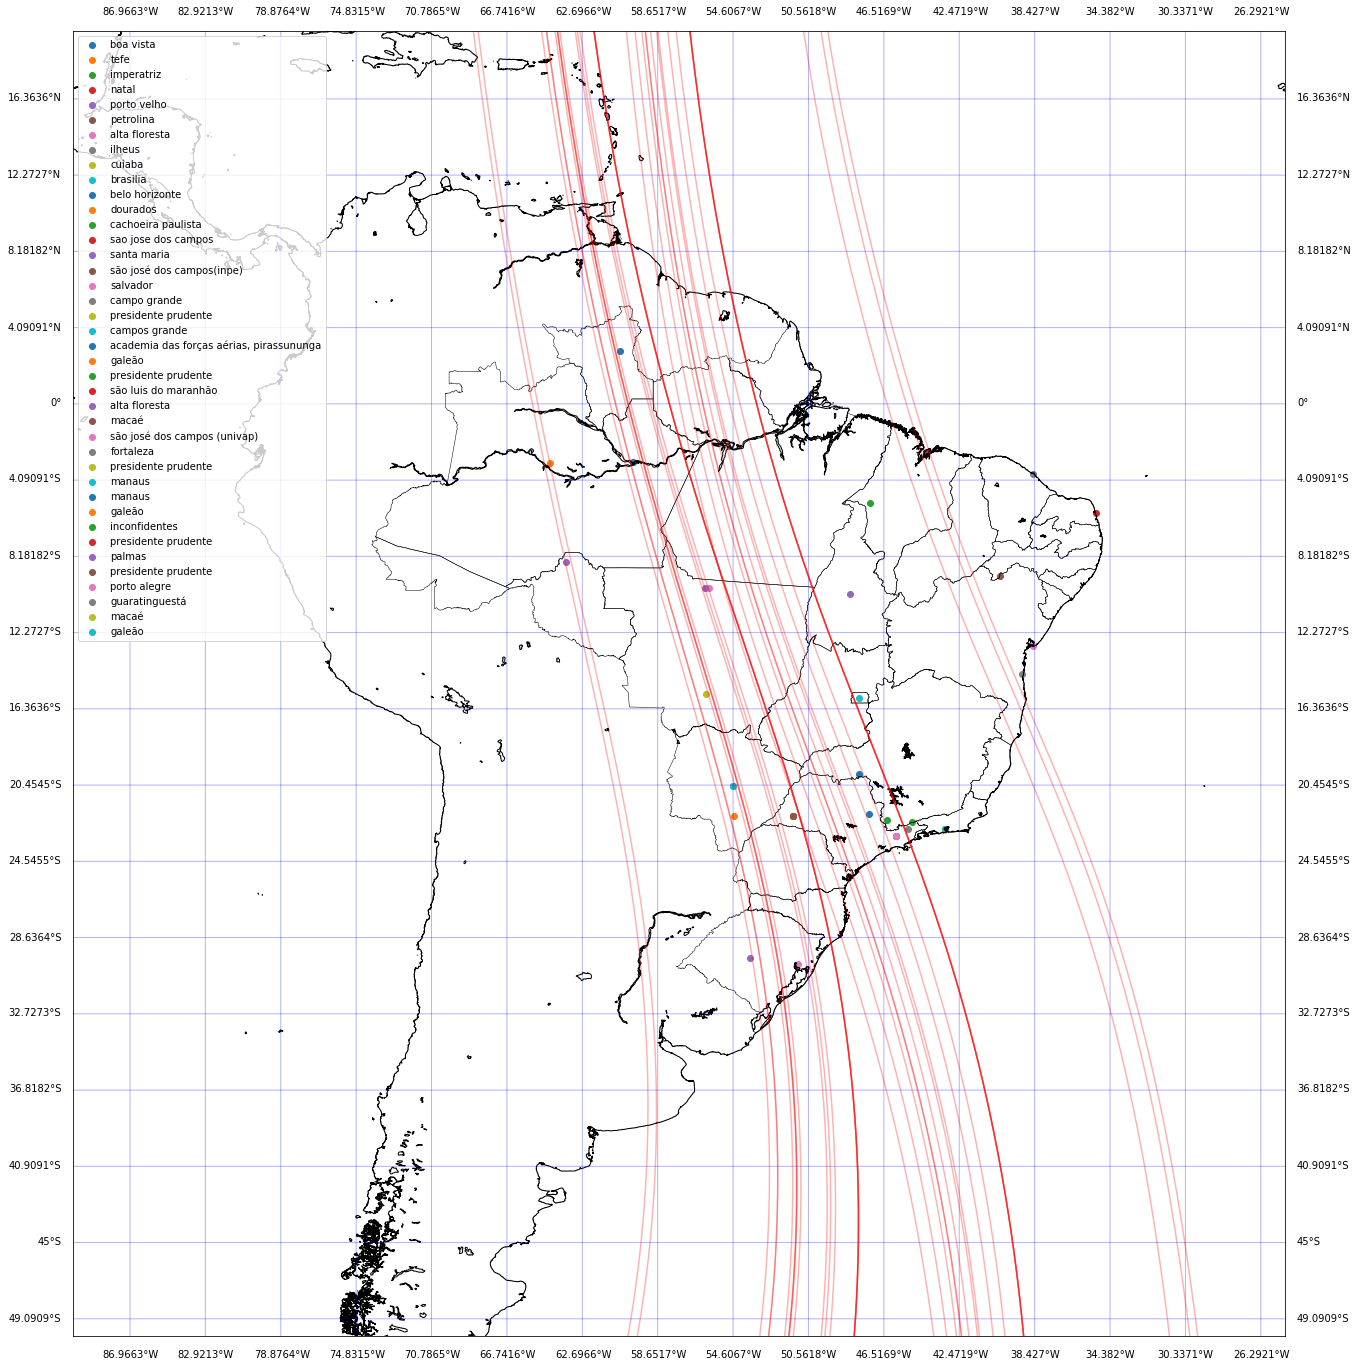

In [6]:
fig = plt.figure(figsize=(24, 24), edgecolor='w')
m = Basemap(projection='cyl',
            resolution='f',
            llcrnrlat=-50,
            urcrnrlat=20,
            llcrnrlon=-90,
            urcrnrlon=-25)
m.drawcoastlines()
m.readshapefile(os.path.join(local_data, 'estados_2010/estados_2010'), 'estados', )
draw_map(m)

for i in mag_meridians_lines:
    m.plot(i[0], i[1], latlon=True, color='r', alpha=0.3)

for i in df_station.itertuples():
    m.scatter(i.longitude, i.latitude, latlon=True, label=i.city)
#    m.text(i.longitude, i.latitude, i.city, latlon=True)
    
plt.legend()
plt.savefig('./images/map_stations.svg', format='svg', dpi=1000)
plt.show()

In [ ]:
df_station.sort_values(by=['state'])